In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import matplotlib as mpl

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.colors
import numpy as np
import glob
import re 

In [2]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## Input, preprocessing

In [3]:
# file_base = 'data/Fun4All_G4_EICDetector_MaterialScan_'
file_base = 'data/Fun4All_G4_EICDetector_ECCE_Prop4_A'

filenames = glob.glob(os.path.join(f'{file_base}*.log'))
print(len(filenames))
filenames.sort();

DataSetLables = {
    1: 'Vacuum',
    2: 'Au-coated beam chamber',
    3: 'Barrel silicon',
    4: 'Barrel muRwell',
    5: 'Forward/backward silicon',
    6: 'Forward/backward GEMs',
    7: 'DIRC',
    8: 'mRICH AeroGel',    
    9: 'Dual RICH',
    10: 'Forward LGAD',
    11: 'Backward LGAD',
    12: 'Barrel LGAD',
    13: 'Backward EMCal',
    14: 'Inner det. spt./service',
    15: 'BCal',
    16: 'BCal Support',
    17: 'SC Magnet',
    18: 'Barrel HCal',
    19: 'Backward HCal',
    20: 'Forward EMCal',
    21: 'Forward LHCal',
};
print('Mapping: ', DataSetLables)

CautiousLabel = 'prop.4, July-2021 concept'

mpl.style.use('seaborn-talk')
colors = np.concatenate((pylab.cm.tab20(np.linspace(0,1,21))[0:19],  pylab.cm.tab20b(np.linspace(0,1,21))[0:19]) )

22
Mapping:  {1: 'Vacuum', 2: 'Au-coated beam chamber', 3: 'Barrel silicon', 4: 'Barrel muRwell', 5: 'Forward/backward silicon', 6: 'Forward/backward GEMs', 7: 'DIRC', 8: 'mRICH AeroGel', 9: 'Dual RICH', 10: 'Forward LGAD', 11: 'Backward LGAD', 12: 'Barrel LGAD', 13: 'Backward EMCal', 14: 'Inner det. spt./service', 15: 'BCal', 16: 'BCal Support', 17: 'SC Magnet', 18: 'Barrel HCal', 19: 'Backward HCal', 20: 'Forward EMCal', 21: 'Forward LHCal'}


In [4]:
temp = re.compile("^\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s+([-+]?\d*\.?\d*)\s*$") 
Setups = [];
Thetas = [];
Phis = [];
Lengths = [];
x0s = [];
lambda0s = [];

for filename in filenames:
    
    filename_base = os.path.basename(filename)
    
    setupID = int(filename_base.split('.')[0].split('_')[-1]);
    
    if setupID not in DataSetLables.keys() :
        print(f'Skip {setupID}: {filename}')
        continue;
    
    cnt = 0;
    file1 = open(filename, 'r') 
    Lines = file1.readlines() 
    for line in Lines: 
    #     line = line.strip();  

        match = temp.match(line) 

        if match:
            res = match.groups()
            if (len(res) == 5):

    #             print (line)
    #             print (res)            
                scanData = [float(n) for n in res]

                if (scanData[1]<=360 ):
                    Setups.append(setupID) 
                    Thetas.append(scanData[0]) 
                    Phis.append(scanData[1]) 
                    Lengths.append(scanData[2]) 
                    x0s.append(scanData[3]) 
                    lambda0s.append(scanData[4]) 

                    cnt = cnt +1
                
    print(f'{setupID}: {filename} -> {cnt} records')
    
    


Skip 0: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_0.log
1: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_1.log -> 0 records
10: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_10.log -> 2884 records
11: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_11.log -> 2884 records
12: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_12.log -> 2884 records
13: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_13.log -> 2884 records
14: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_14.log -> 2884 records
15: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_15.log -> 2884 records
16: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_16.log -> 2884 records
17: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_17.log -> 2884 records
18: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_18.log -> 2884 records
19: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_19.log -> 2884 records
2: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_2.log -> 2884 records
20: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_20.log -> 2884 records
21: data/Fun4All_G4_EICDetector_ECCE_Prop4_A_21.log -> 2884 records


In [5]:
df = pd.DataFrame(
    {'Setup':Setups, 
     'Theta':Thetas,
     'Phi': Phis,
     'Length': Lengths,
     'x0':x0s,
     'lambda0':lambda0s,
    });
df.set_index(['Setup','Theta','Phi'], inplace=True)
df.sort_index(level = 2)

df

Length        x0   lambda0
Setup Theta    Phi                                  
10    -88.4453 45.3529   6002.21  28.11390  2.908130
               66.5294   6002.21  11.43790  1.183150
               87.7059   6002.21   6.83889  0.707422
               108.8820  6002.21   4.90079  0.506942
               130.0590  6002.21   3.98228  0.411931
...                          ...       ...       ...
9      88.4453 257.1180  6002.21  24.55420  2.539910
               278.2940  6002.21   8.62685  0.892370
               299.4710  6002.21   5.24573  0.542624
               320.6470  6002.21   4.01385  0.415197
               341.8240  6002.21   3.51193  0.363278

[57680 rows x 3 columns]

In [6]:
# ave = df.loc[(9,0),:].mean(axis = 0) 

## Radiation length

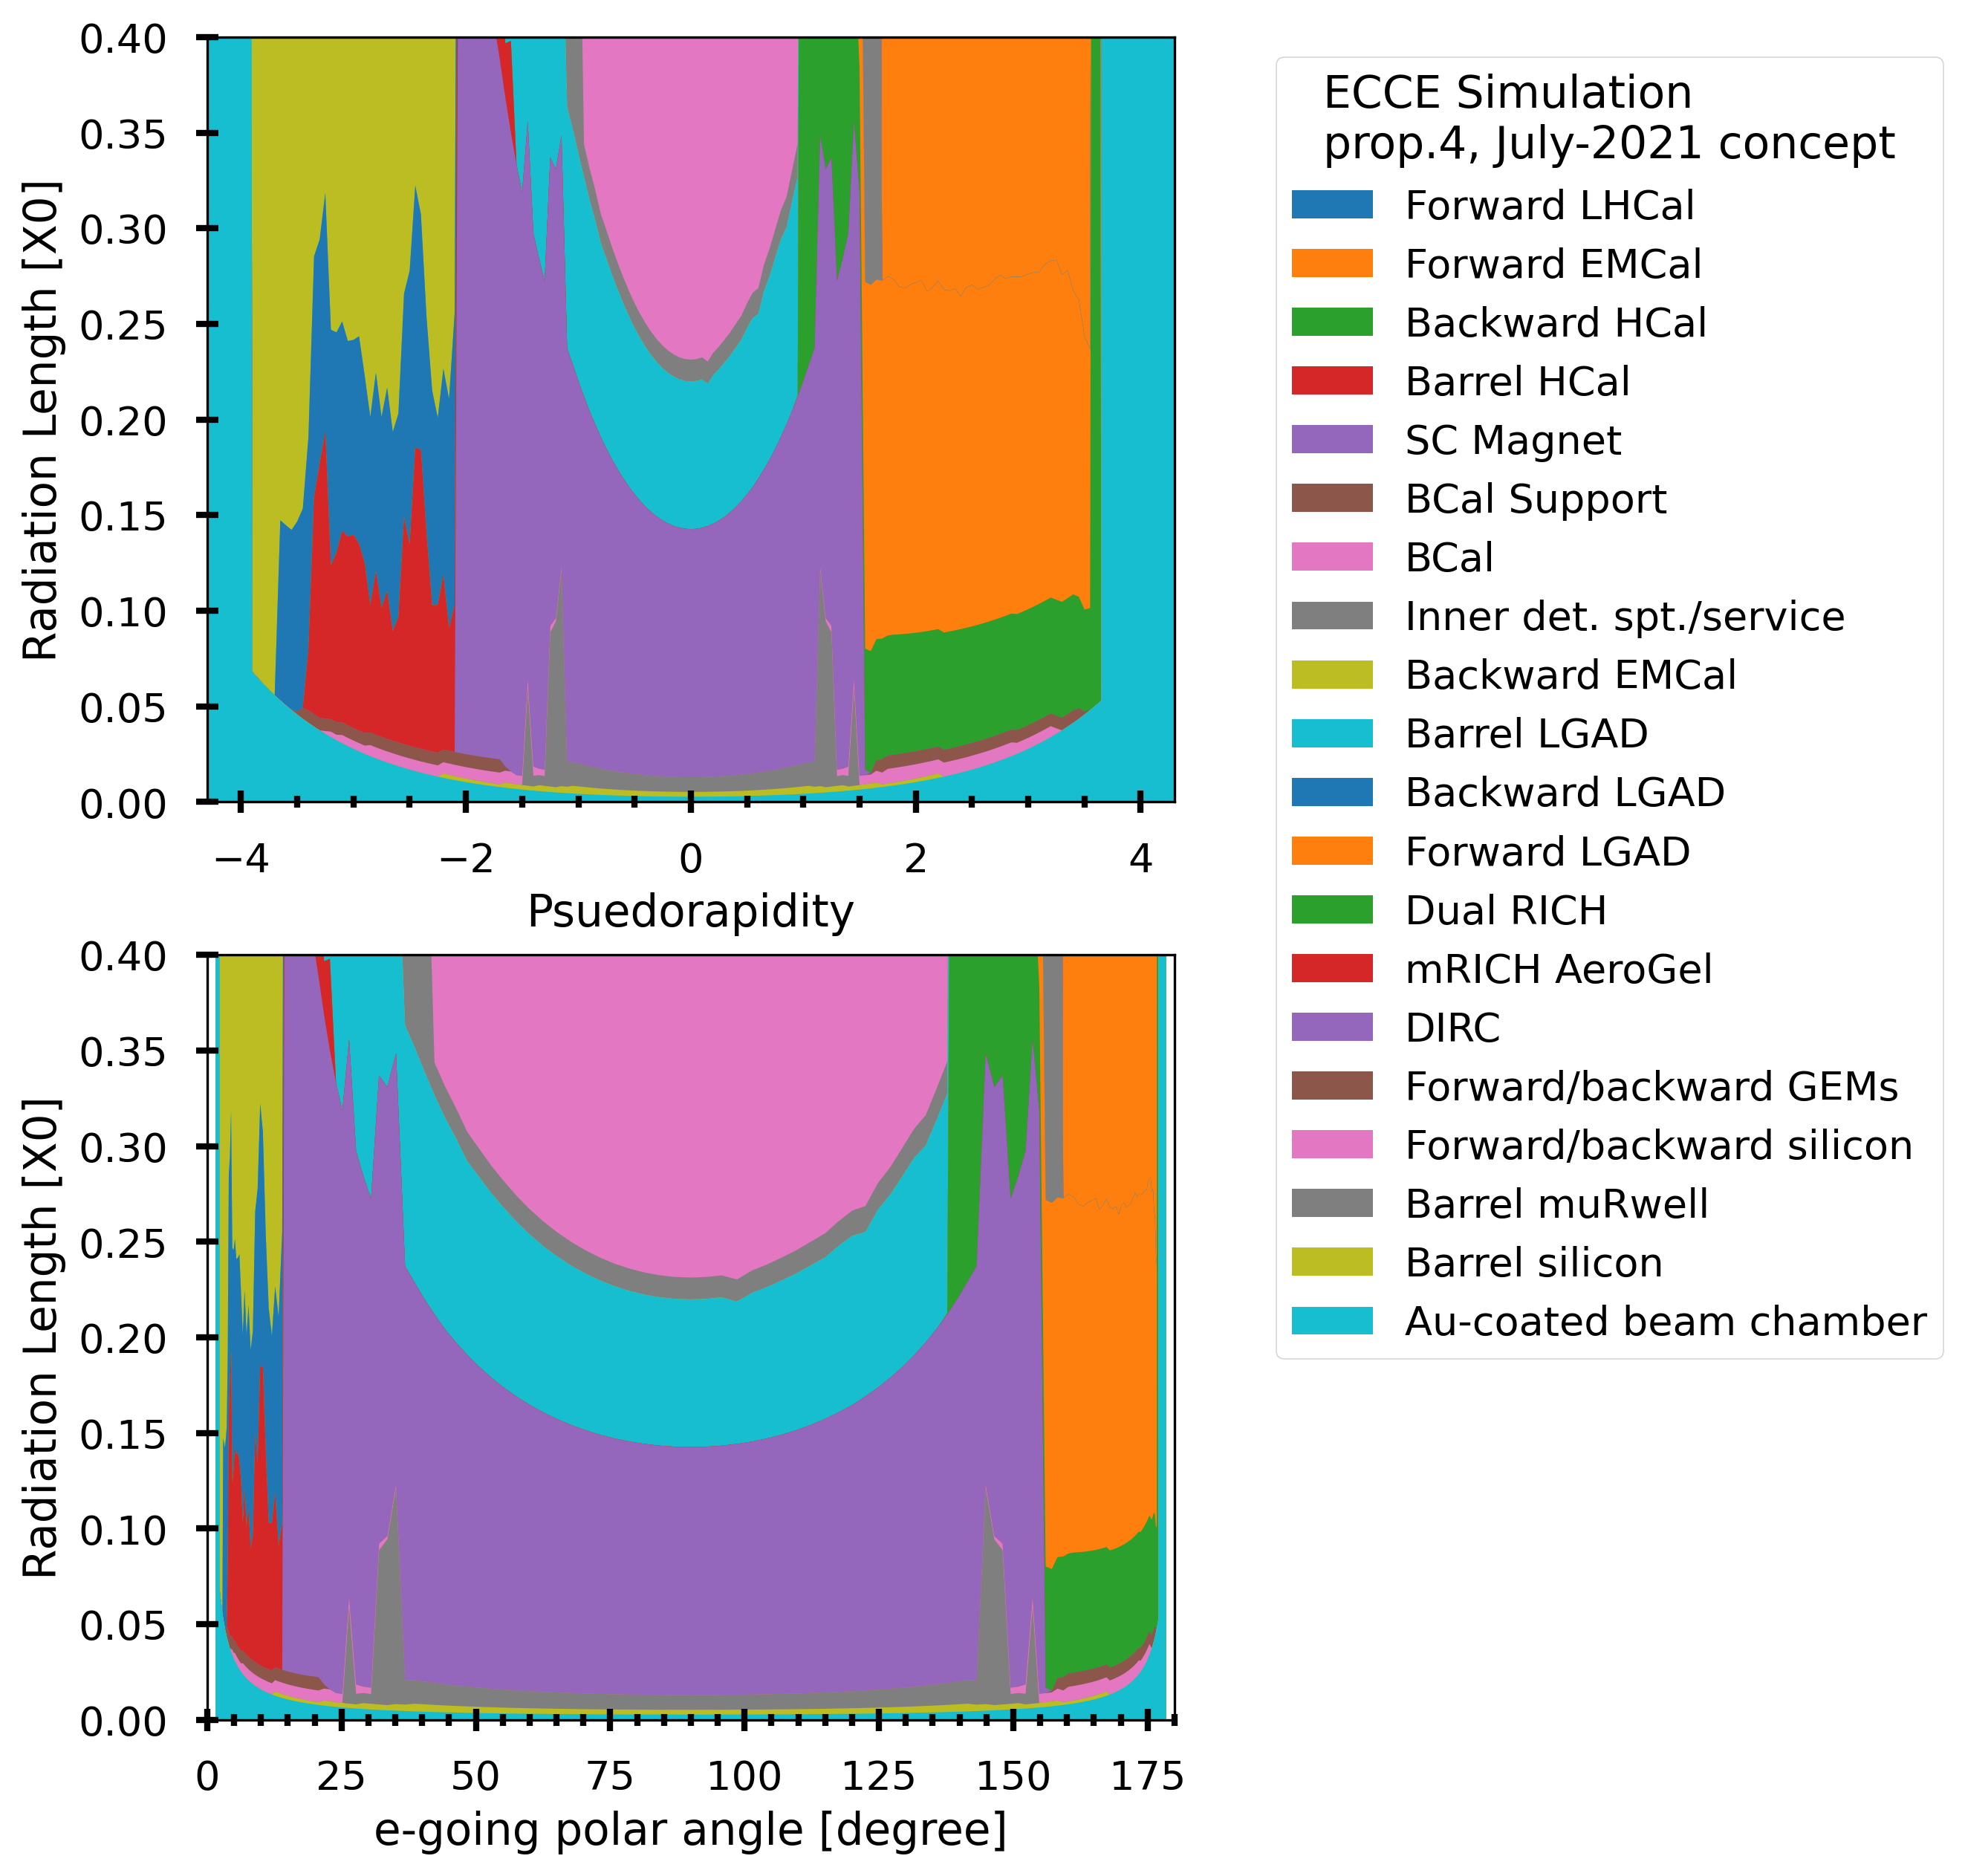

In [7]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)



datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

for dataset in datasets:
    
    x0_avg = df.loc[(dataset),:].groupby('Theta').x0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable)
    
    axs[1].fill_between( polar_angles, 0, x0_avg.to_numpy(), label=DataSetLable)
   

ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Psuedorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 0.4]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]
    
# ax.set_title('Raditioan Length Scans')
# ax.set_yscale('log')
ax.set_xlabel("e-going polar angle [degree]")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([0, 180]);
ax.set_ylim([0, 0.4]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Raditioan_Length.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Raditioan_Length.png'), bbox_inches='tight')

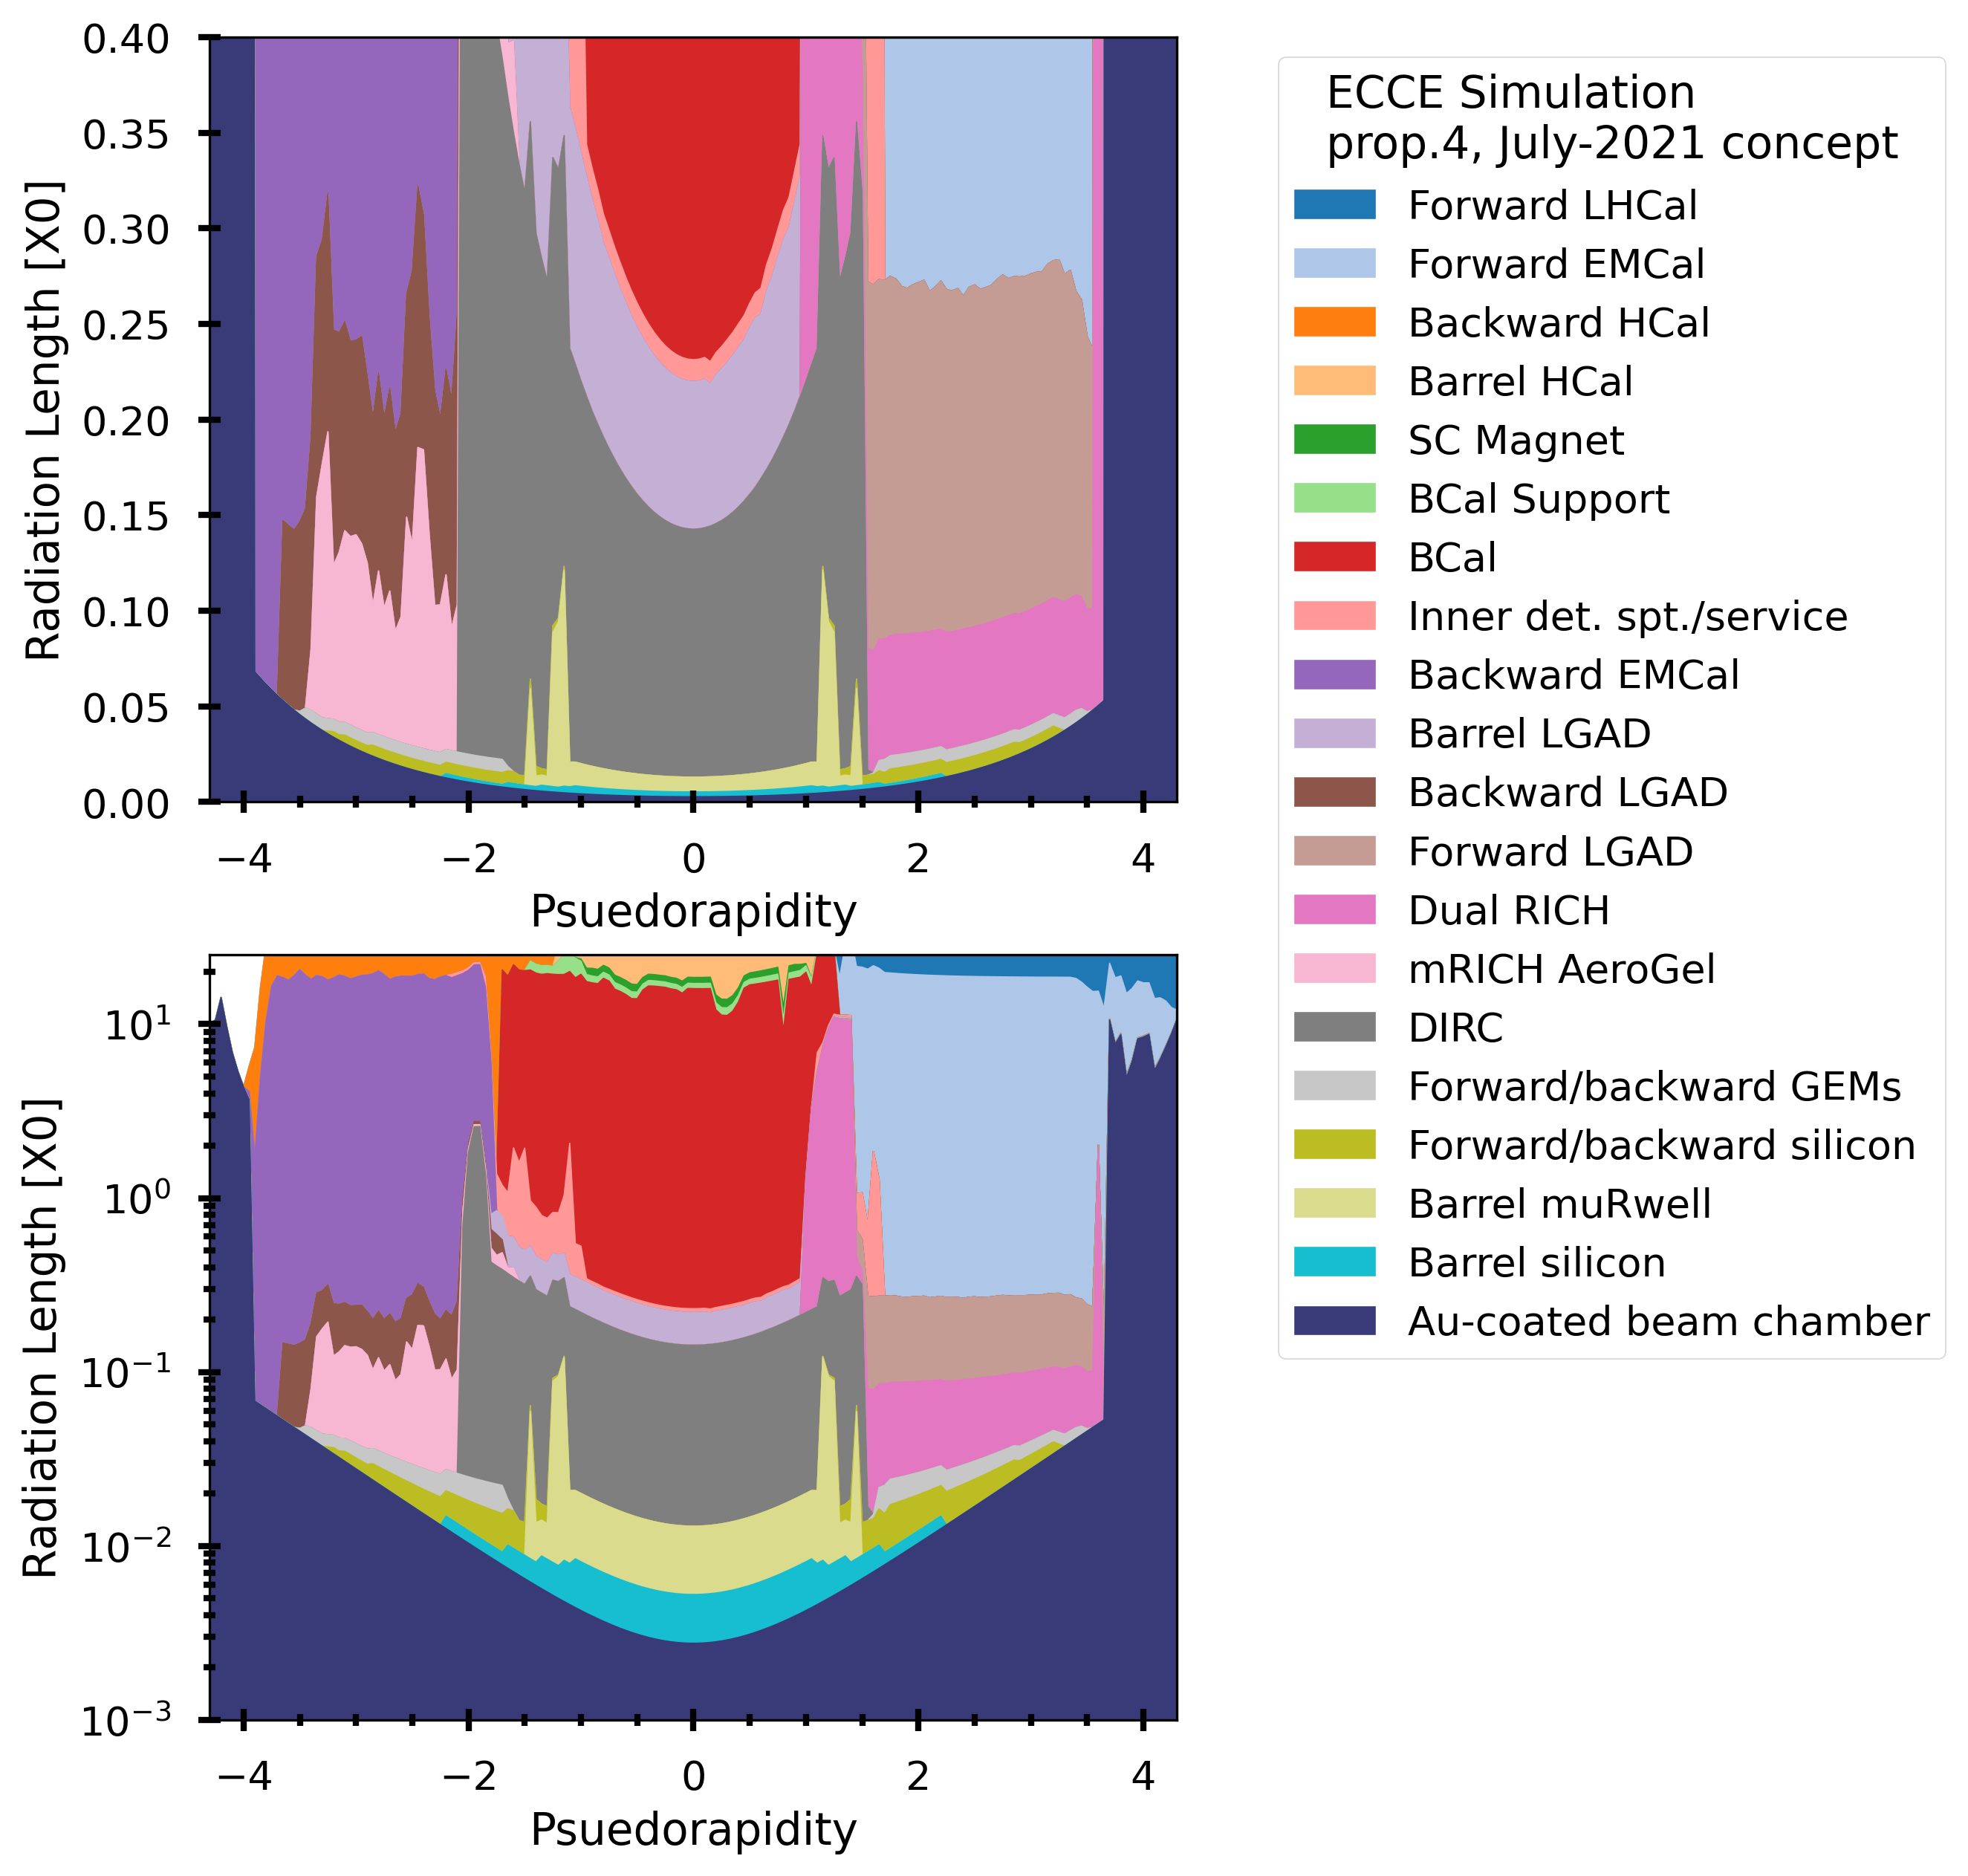

In [8]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)


datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

color_index = 0;

for dataset in datasets:
    
    x0_avg = df.loc[(dataset),:].groupby('Theta').x0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
    
    axs[1].fill_between( etas, 0, x0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
   
    color_index = color_index +1
ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Psuedorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 0.4]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]

ax.set_yscale('log')
ax.set_xlabel("Psuedorapidity")
ax.set_ylabel("Radiation Length [X0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([1e-3, 25]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Raditioan_Length_Log.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Raditioan_Length_Log.png'), bbox_inches='tight')

## Hadronic interaction length

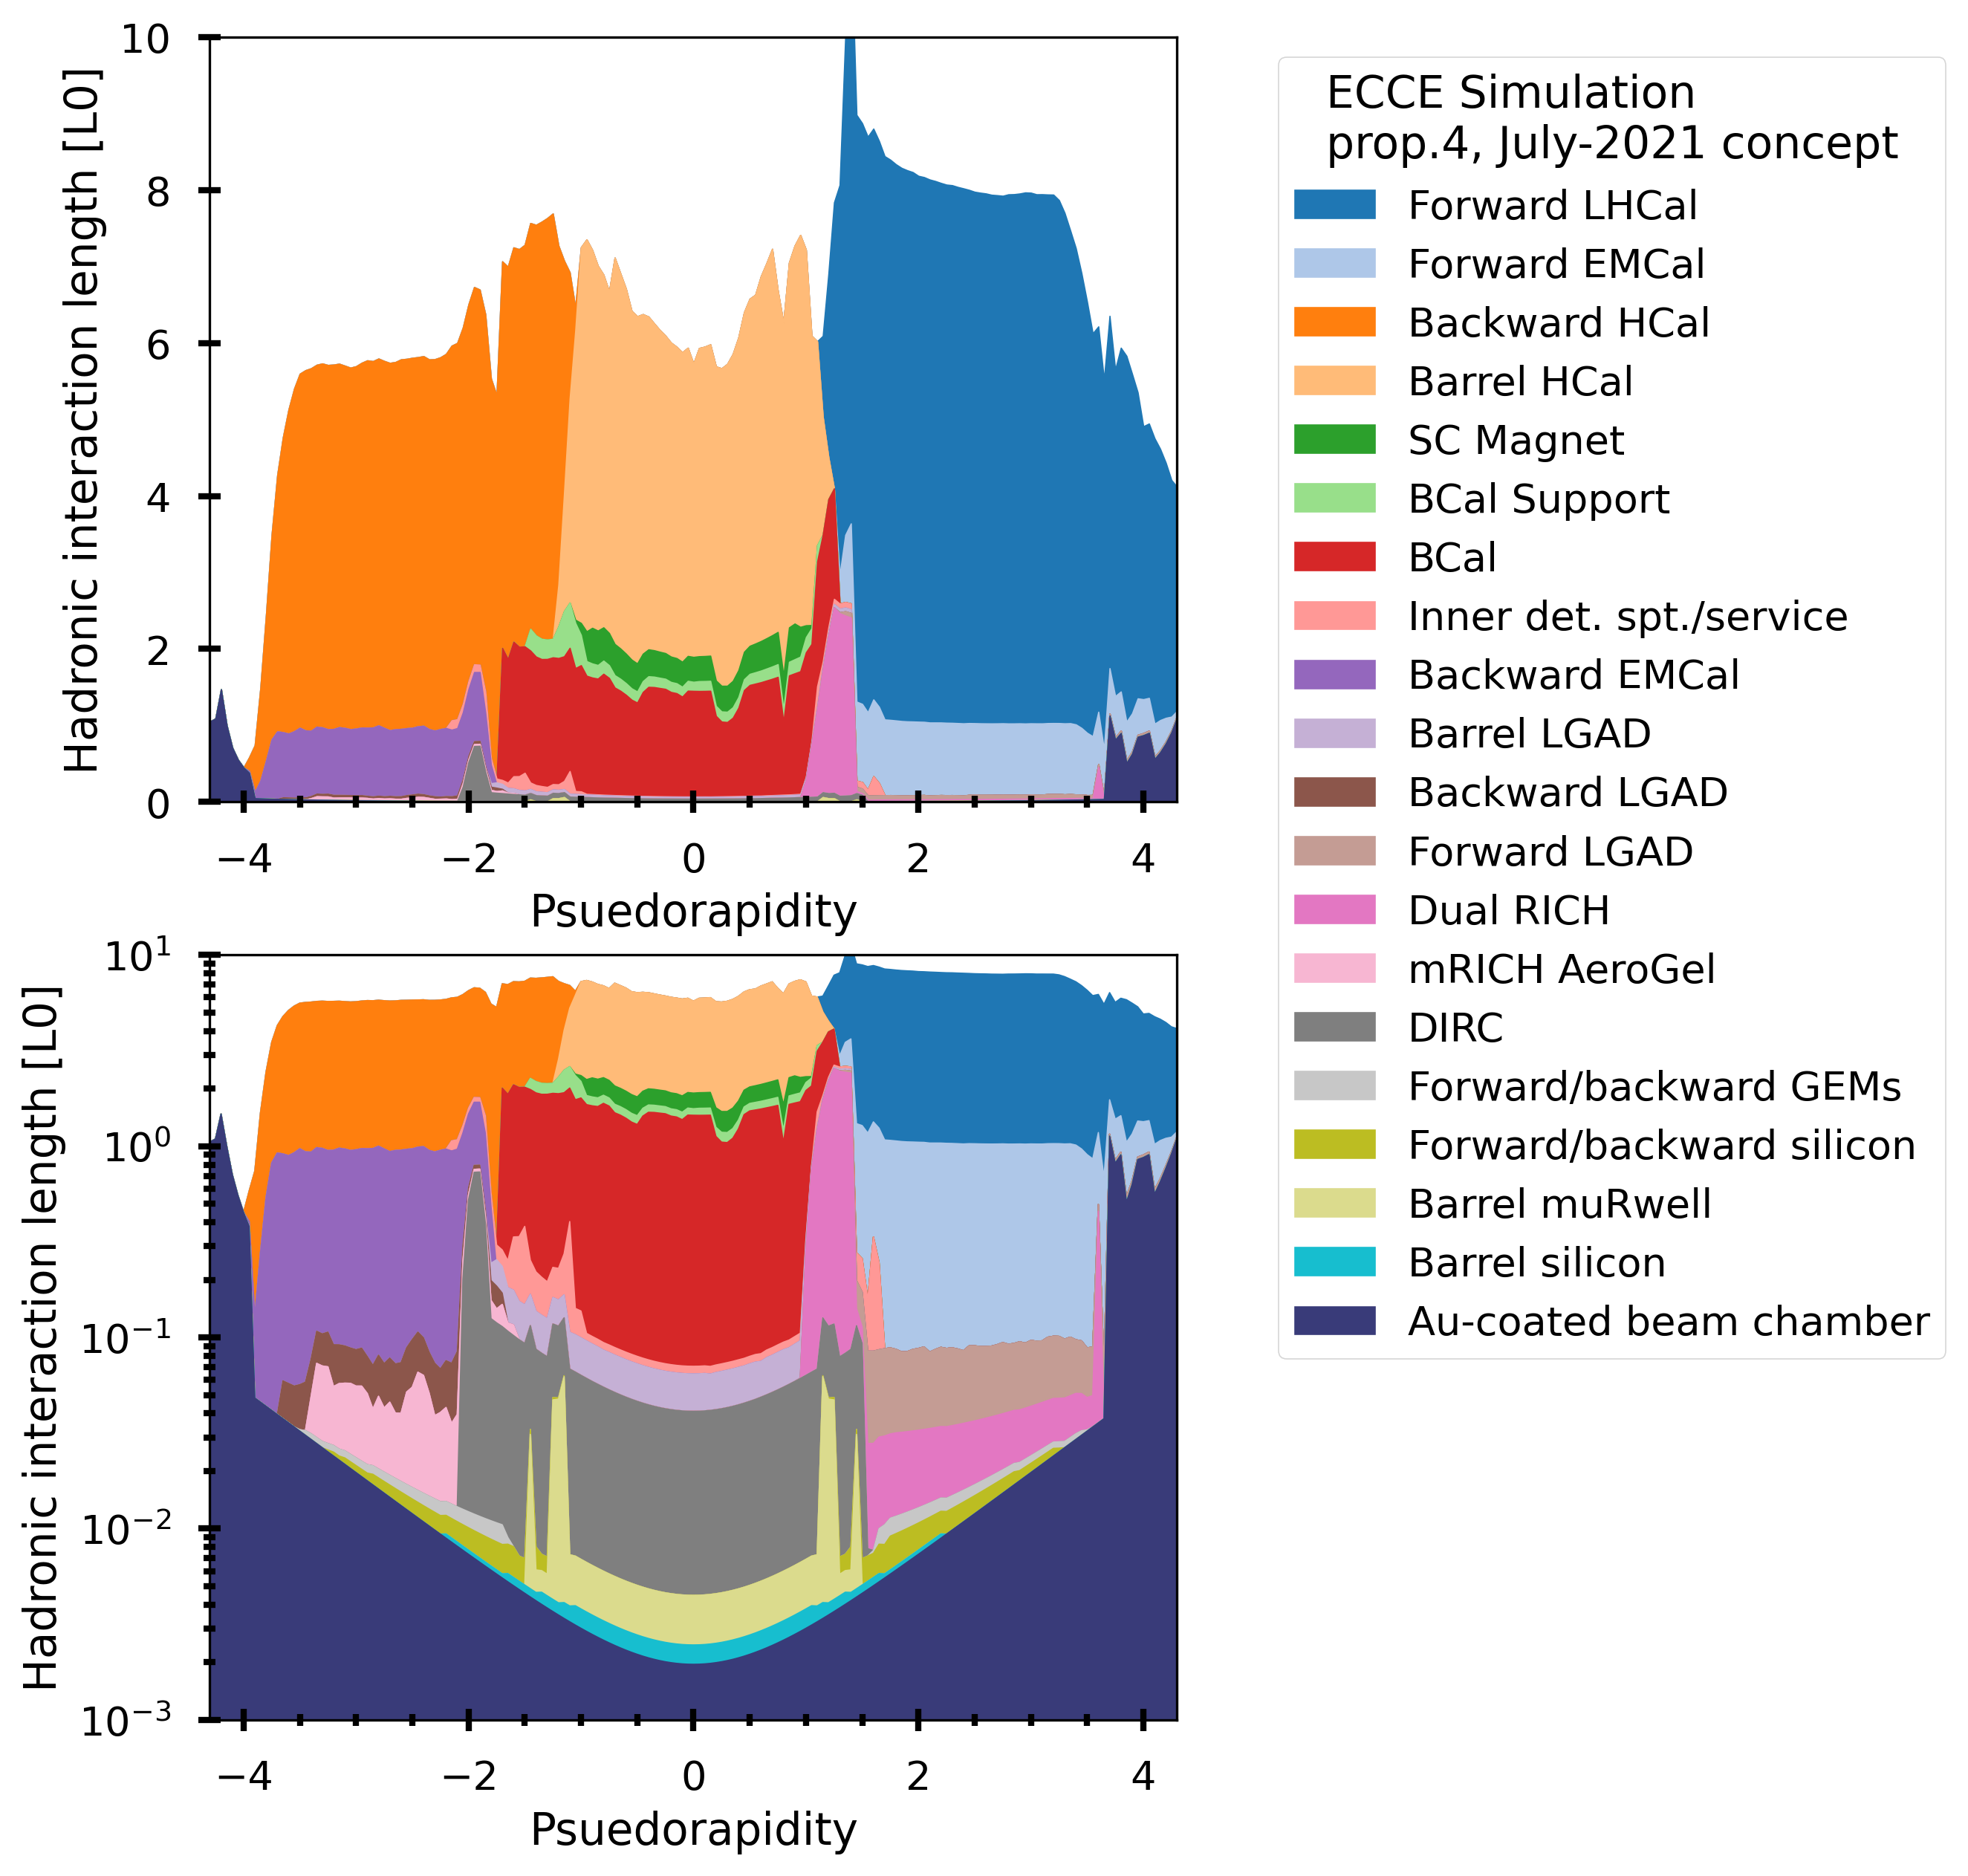

In [9]:
# fig= plt.figure(num=None, figsize=(8, 16), dpi=80, facecolor='w', edgecolor='k')
# ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 10), dpi=300)


datasets = sorted(df.index.levels[0].unique().to_list(), reverse=True)

color_index = 0;

for dataset in datasets:
    
    lambda0_avg = df.loc[(dataset),:].groupby('Theta').lambda0.mean()
    etas = -np.log(np.tan( ((90-x0_avg.index.to_numpy())/180*np.pi)/2 ))
    polar_angles = 180- ( 90-x0_avg.index.to_numpy() )
    DataSetLable = DataSetLables[dataset]
    
    axs[0].fill_between( etas, 0, lambda0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
    
    axs[1].fill_between( etas, 0, lambda0_avg.to_numpy(), label=DataSetLable, color = colors[color_index])
   
    color_index = color_index +1
ax=axs[0]
    
# ax.set_title(f'Fun4All-EIC Simulation. Tracking and PID detectors\n{CautiousLabel}')
# ax.set_yscale('log')
ax.set_xlabel("Psuedorapidity")
ax.set_ylabel("Hadronic interaction length [L0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([0, 10]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
         title = f'ECCE Simulation\n{CautiousLabel}',
         title_fontsize='x-large'
         )

ax=axs[1]

ax.set_yscale('log')
ax.set_xlabel("Psuedorapidity")
ax.set_ylabel("Hadronic interaction length [L0]")
ax.set_xlim([-4.3, 4.3]);
ax.set_ylim([1e-3, 10]);

ax.tick_params(which='both',direction='inout');
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4)

chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.7, chartBox.height])
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), ncol=1,
#          title = f'Fun4All-EIC Simulation\nTracking and PID detectors\n{CautiousLabel}',
#          title_fontsize='x-large'
#          )

plt.savefig(os.path.join(f'{file_base}_Hadronic_Interaction_Length_Log.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(f'{file_base}_Hadronic_Interaction_Length_Log.png'), bbox_inches='tight')

In [10]:
((90-x0_avg.index.to_numpy())/180*np.pi)/2

array([1.55722901, 1.55653262, 1.5558022 , 1.55503339, 1.5542253 ,
       1.55337532, 1.55248259, 1.5515436 , 1.55055749, 1.54951989,
       1.54842906, 1.54728325, 1.5460781 , 1.54481099, 1.54347931,
       1.54207955, 1.54060824, 1.53906101, 1.53743523, 1.53572655,
       1.53392974, 1.53204129, 1.53005685, 1.52797031, 1.5257773 ,
       1.5234726 , 1.52105008, 1.51850452, 1.51582893, 1.51301633,
       1.51006149, 1.50695567, 1.50369191, 1.50026234, 1.4966591 ,
       1.49287261, 1.48889501, 1.48471582, 1.48032631, 1.47571515,
       1.47087099, 1.4657851 , 1.46044352, 1.45483491, 1.44894617,
       1.44276595, 1.43627857, 1.42947091, 1.42232815, 1.41483632,
       1.40697885, 1.3987409 , 1.39010501, 1.38105635, 1.37157746,
       1.36165178, 1.3512627 , 1.34039192, 1.32902285, 1.31713977,
       1.30472612, 1.29176618, 1.27824424, 1.26414721, 1.24946201,
       1.23417729, 1.21828258, 1.20177176, 1.18463961, 1.16688176,
       1.14850082, 1.12949855, 1.10988454, 1.08966839, 1.06886

In [11]:
dir(ax)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_box_aspect',
 '_clipon',
 '_clippath',
 '_contains',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_axis_map',
 '_get_clipping_extent_bbox',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_in_layout',

In [12]:
len(datasets)

20

In [13]:
linspace(0,1,20)

NameError: name 'linspace' is not defined

In [ ]:

colors = pylab.cm.tab20(np.linspace(1,0,21))
colors = np.concatenate((colors[0:19], colors[0:19]))

In [ ]:
colors